# Time series Concepts and modelling

In this notebook, we shall study and experiment with the statistical tools used for time series data. We will begin with examining characteristics of a time series followed by modelling it. As an example, we take "node_memory_Active_bytes" which are the memory bytes that have been recently used by a node. It reflects the memory pressure on the node.
This notebook can be used as a guideline to analyze, understand, and model any time series data. 

## Contents

- Load data
- Concepts
    - Standard time series
      - White noise
      - Random walk
    - Stationarity 
      - Dicky Fuller Test
    - Seasonality
      - Naive decomposition - Additive 
      - Multiplicative
      - Synthetic seasonal data
    - Auto Correlation
      - ACF
      - PACF
- Modelling
    - Manual
        - AR
        - MA
        - ARMA
        - ARIMA
        - SARIMAX
    - Automatic 
        - Auto ARIMA

## Load Data

In [1]:
from prometheus_api_client import PrometheusConnect  # noqa: F401
from prometheus_api_client.metric_range_df import (  # noqa: F401
    MetricRangeDataFrame,
)
from datetime import timedelta, datetime  # noqa: F401
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from scipy.stats.distributions import chi2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import warnings

warnings.filterwarnings("ignore")

In [2]:
## To ensure reproducibilty, use the saved snapshot of time series data.
## For modelling on your own as an exercise, fetch new data using this cell.

# # Creating the prometheus connect object with the required parameter
# prom_url = "http://demo.robustperception.io:9090"
# pc = PrometheusConnect(url=prom_url, disable_ssl=True)

# # Request fixed data for 1 week
# start_time = datetime(2021, 2, 2)
# end_time = datetime(2021, 2, 9)
# metric_data = pc.get_metric_range_data(
#     "node_memory_Active_bytes",  # metric name and label config
#     start_time=start_time,  # datetime object for metric range start time
#     end_time=end_time,
#     chunk_size=timedelta(
#         days=1
#     ),  # timedelta object for duration of metric data downloaded in one request
# )

# ## Make the dataframe
# metric_df = MetricRangeDataFrame(metric_data)
# metric_df.index = pd.to_datetime(metric_df.index, unit="s", utc=True)
# ## Save the sanpshot of the data to ensure reproducibility
# metric_df.to_pickle("../data/raw/ts.pkl")

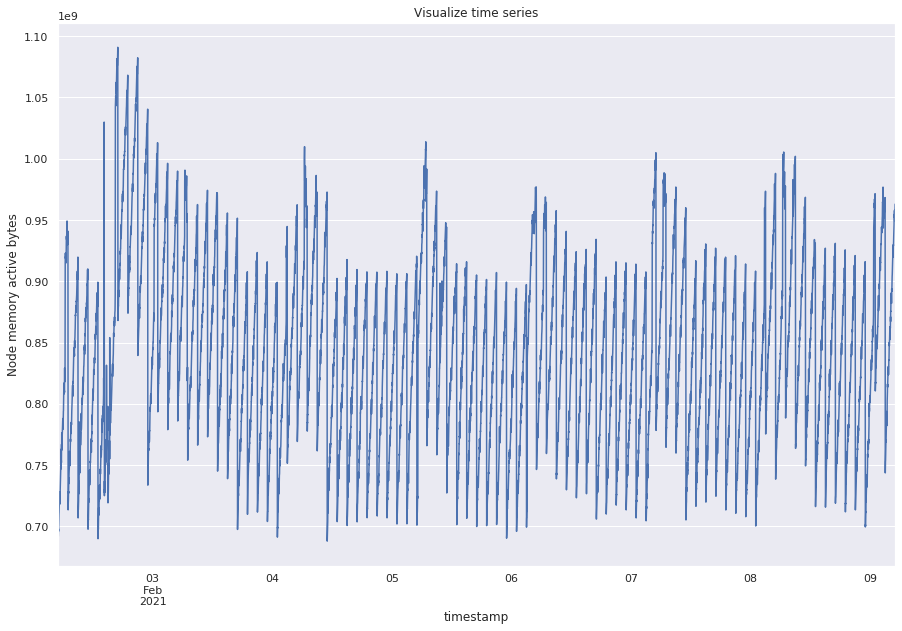

In [3]:
metric_df = pd.read_pickle("../data/raw/ts.pkl")
ts = metric_df["value"].astype(float).resample("min").mean()
sns.set()
ts.plot(figsize=(15, 10))
plt.title("Visualize time series")
plt.ylabel("Node memory active bytes")
plt.show()

## Concepts

### Standard time series
Before defining statistical properties, let's understand two standard time series: white noise and random walk. These time series are often used to understand and compare others.

#### [White noise](https://en.wikipedia.org/wiki/White_noise)
- White noise has constant mean, constant variance, and no autocorrelation (no relationship between past and present of time series)

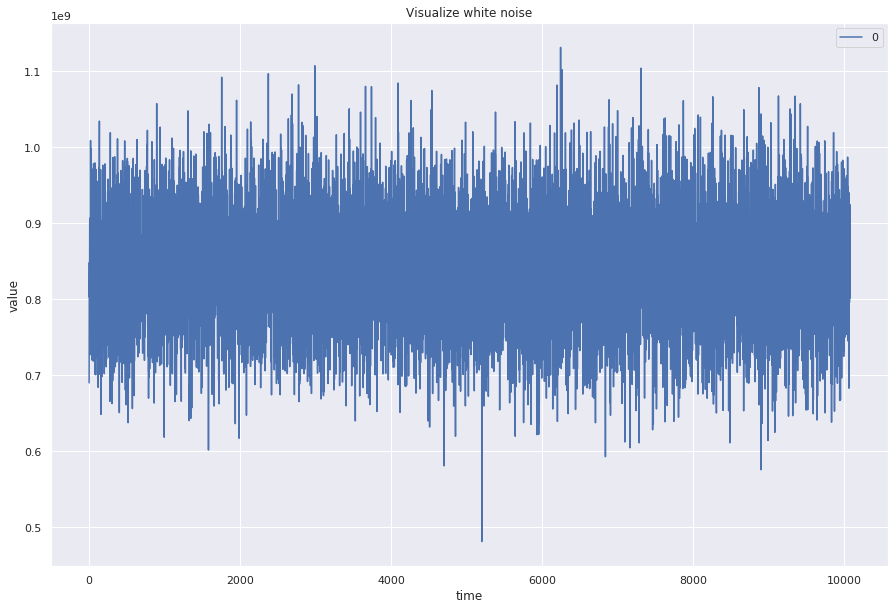

In [8]:
## Create a wn time series with mean, std, length same as our loaded data
wn = np.random.normal(loc=ts.mean(), scale=ts.std(), size=len(ts))
pd.DataFrame(wn).plot(figsize=(15, 10))
plt.title("Visualize white noise")
plt.ylabel("value")
plt.xlabel("time")
plt.show()

#### [Random walk](https://towardsdatascience.com/random-walks-with-python-8420981bc4bc)
- A random walk is modelled using this equation: P<sub>t</sub> = P<sub>t-1</sub> + $\epsilon$<sub>t</sub> where $\epsilon$<sub>t</sub> is white noise. 
- Random walks are not predictable

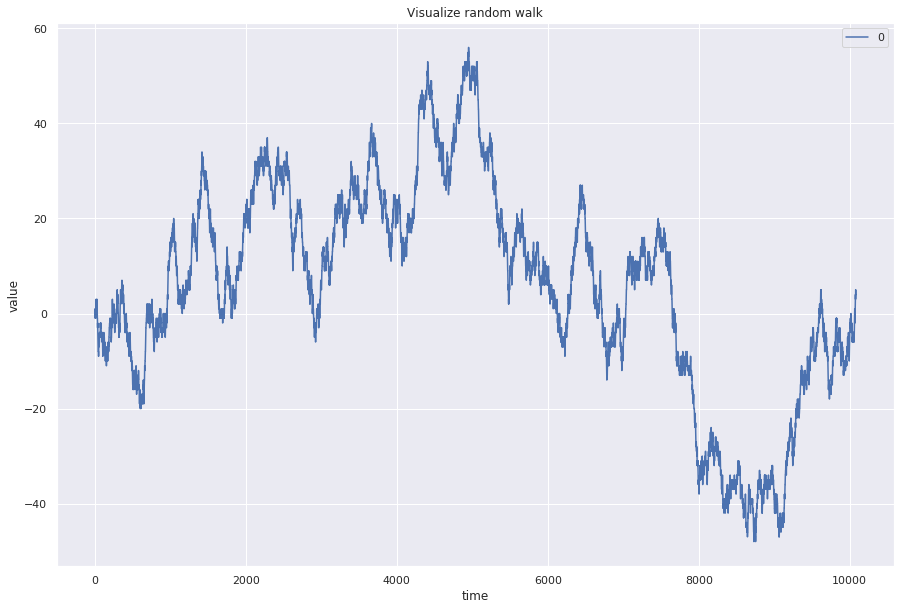

In [5]:
## Randomly choose from -1, 0, 1 for the next step
random_steps = np.random.choice(a=[-1, 0, 1], size=(len(ts), 1))
rw = np.concatenate([np.zeros((1, 1)), random_steps]).cumsum(0)
pd.DataFrame(rw).plot(figsize=(15, 10))
plt.title("Visualize random walk")
plt.ylabel("value")
plt.xlabel("time")
plt.show()

### [Stationarity](https://towardsdatascience.com/stationarity-in-time-series-analysis-90c94f27322)

Intuitively, a stationary time series does not change the way it changes. In other words, the statistical properties of the process generating the time series does not change over time. For real world problems, we use the weak form or covariance stationarity definition:
- Constant $\mu$
- Constant $\sigma$
- Cov (x<sub>n</sub>, x<sub>n+k</sub>) = Cov (x<sub>m</sub>, x<sub>m+k</sub>)

Ideally we would want the time series to be stationary for modelling. In the real world it is rarely stationary. We shall now look at the Dickey Fuller Test which determines if a series is stationary or not. 



## Dickey Fuller Test
- This test determines if the time series is stationary or not.
- If p value > 0.05 then process is not stationary.
- If p < 0.05, null hypothesis is rejected and the process is stationary.

In [6]:
dft = adfuller(ts)
print(
    f"p value {round(dft[1], 4)}",
    f"\n Test statistic {round(dft[0], 4)}",
    f"\n Critical values {dft[4]}",
)

p value 0.0 
 Test statistic -13.1299 
 Critical values {'1%': -3.431000972468946, '5%': -2.8618276912593523, '10%': -2.5669231329178066}


For this series, the p-value is 0 which means that the null hypothesis can be rejected and the series is stationary. The test statistic of -15.6815 is less than 1% critical value (-3.4304) meaning that the chances of this result being a fluke is less than 1%. 

In [7]:
## Examining white noise
dft = adfuller(wn)
print(
    f"p value {round(dft[1], 4)}",
    f"\n Test statistic {round(dft[0], 4)}",
    f"\n Critical values {dft[4]}",
)

p value 0.0 
 Test statistic -70.0778 
 Critical values {'1%': -3.4309990341724883, '5%': -2.861826834740749, '10%': -2.5669226769920557}


In [8]:
## Examining random walk
dft = adfuller(rw.squeeze())
print(
    f"p value {round(dft[1], 4)}",
    f"\n Test statistic {round(dft[0], 4)}",
    f"\n Critical values {dft[4]}",
)

p value 0.7345 
 Test statistic -1.0503 
 Critical values {'1%': -3.4309989697613776, '5%': -2.861826806277955, '10%': -2.566922661841282}


As we can see from the above, we know by definition that that white noise is stationary and the random walk is not. Since the results of the Dickey Fuller test verified our expected results, we know that we can at least have some confidence in this statistical test when it indicates to us that our real world time series data set is stationary. 

### Seasonality
- There are certain trends in some time series that appear cyclically.
- We can decompose the time series data into trend, seasonal, residual
- Trend: general pattern present in the time series
- Seasonal: cyclical effect in the time series
- Residual: Error of prediction

#### Naive Decomposition
One way to decompose a time series in order to check for seasonality is through naive decomposition that assumes an additive or multiplicative nature between the three components: trend, seasonal, residual.

Additive
- Observed = trend + seasonal + residual

Multiplicative
- Observed = trend * seasonal * residual

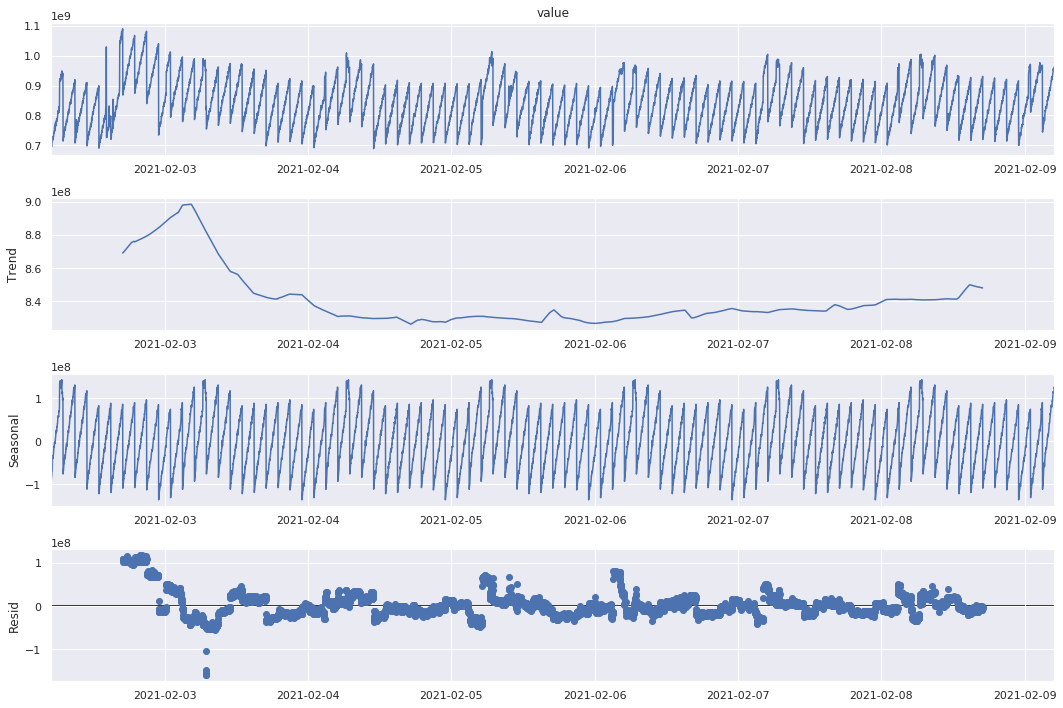

In [9]:
# Since this is minutely data, we set freq=60*24 implying that we need to focus on one day
# We need to manually gauge this parameter in order to come up with the right decomposition
# We can change it to 60 to focus on hourly decomposition as well
sd_add = seasonal_decompose(ts, model="additive", freq=60 * 24)
sd_add.plot()  # Image manipulation doesn't work here.
plt.rc("figure", figsize=(15, 10))
plt.show()

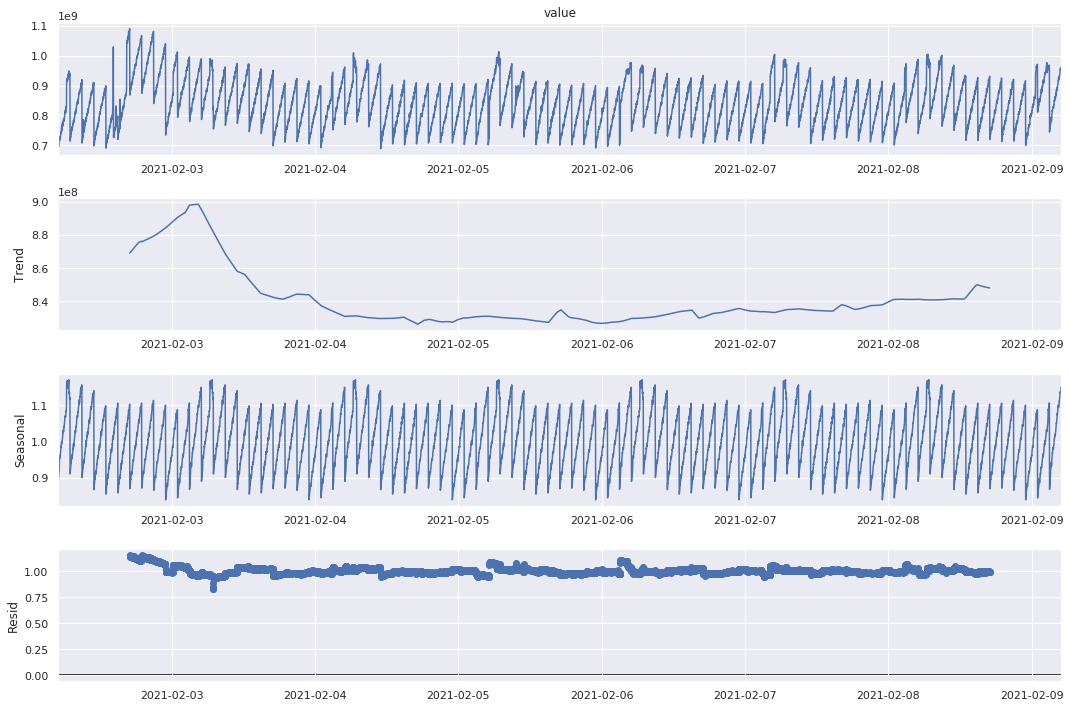

In [7]:
# Since this is minutely data, we set freq=60*24 implying that we need to focus on one day
# We need to manually gauge this parameter in order to come up with the right decomposition
# We can change it to 60 to focus on hourly decomposition as well
sd_add = seasonal_decompose(ts, model="multiplicative", freq=60 * 24)
sd_add.plot()  # Image manipulation doesn't work here.
plt.rc("figure", figsize=(15, 10))
plt.show()

Both additive and multiplicative models give a similar output. There is a downward trend in memory usage at the begining of the week and it remains low throughout the week increasing slightly towards the end. The seasonal values show an oscillating behavior, however we can see that within a day, it starts high and reduces towards the end. The residuals however do not seem exactly random (like white noise) indicating that the decomposition is not perfect.
For a better understanding, let's try these methods on a synthetic seasonal time series.

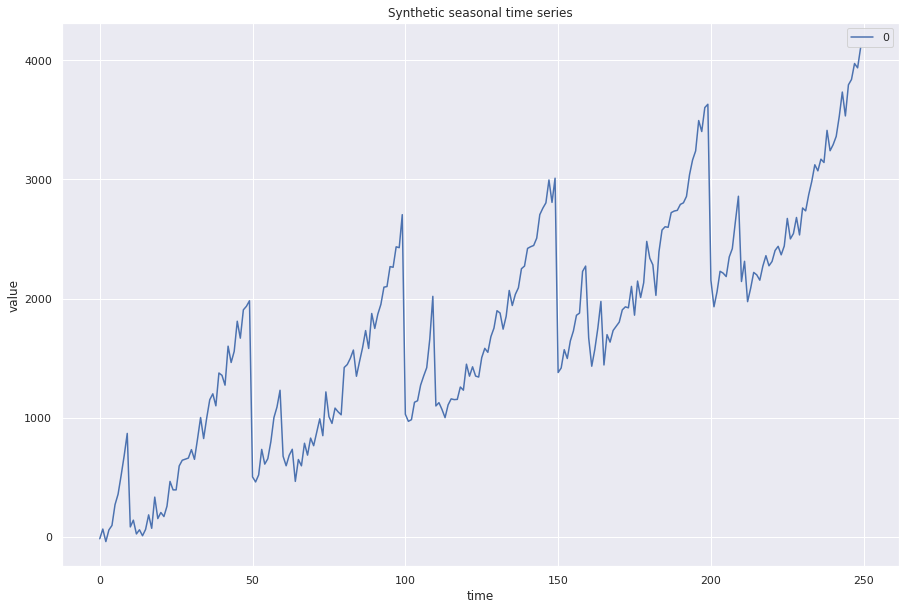

In [10]:
time = np.arange(50)
## Create a pattern
values = np.where(time < 10, time ** 3, (time - 9) ** 2)
## Repeat it several times
seasonal = np.hstack((values, values, values, values, values))
## Add noise
noise = np.random.randn(250) * 100
## Add upward trend
trend = np.arange(250) * 10
## Combine all
synthetic_time_series = seasonal + noise + trend
## Visualize
pd.DataFrame(synthetic_time_series).plot()
plt.xlabel("time")
plt.ylabel("value")
plt.title("Synthetic seasonal time series")
plt.show()

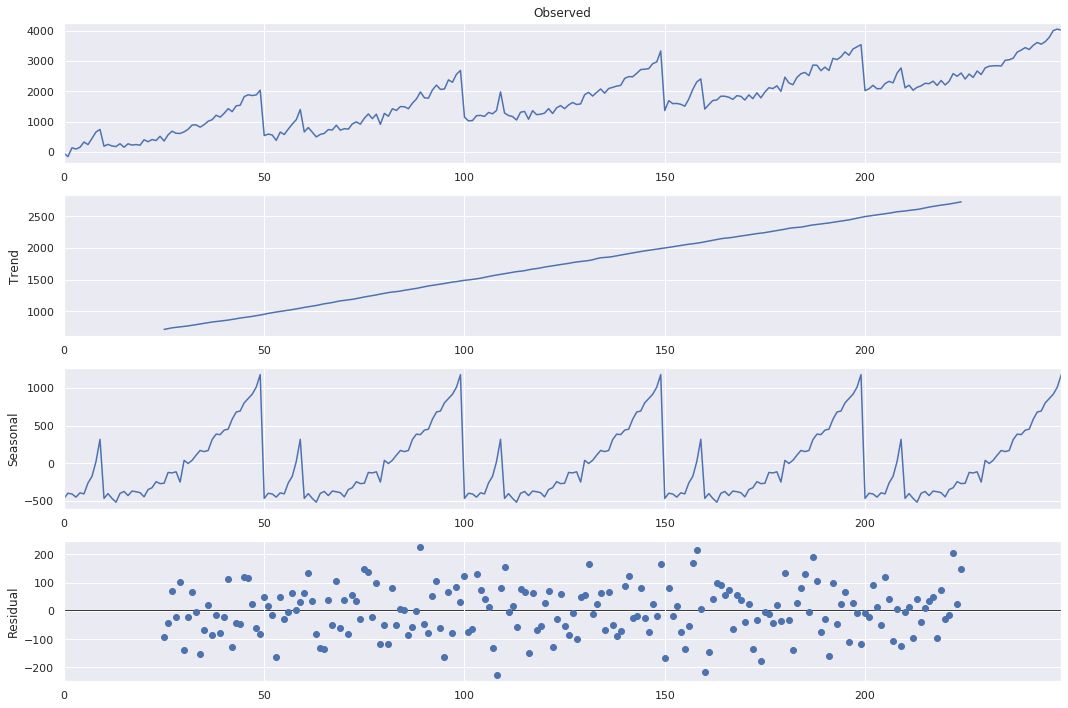

In [12]:
# For this data, we set freq=50 since we repeated a pattern 50 times
# Again, we used additional information to gauge this parameter
sd_add = seasonal_decompose(synthetic_time_series, model="additive", freq=50)
sd_add.plot()  # Image manipulation doesn't work here.
plt.rc("figure", figsize=(15, 10))
plt.show()

No surprises here, but we see that the time series being perfectly decomposed into the trend and the seasonal variations. The residuals look like white noise as well. We can use such decomposition for simpifying and understanding all time series data.

### Auto-correlation
Auto correlation refers to correlation of a time series with a lagged version of itself.

#### [ACF](https://towardsdatascience.com/significance-of-acf-and-pacf-plots-in-time-series-analysis-2fa11a5d10a8)
Auto correlation function for how the number of lags we are interested in.

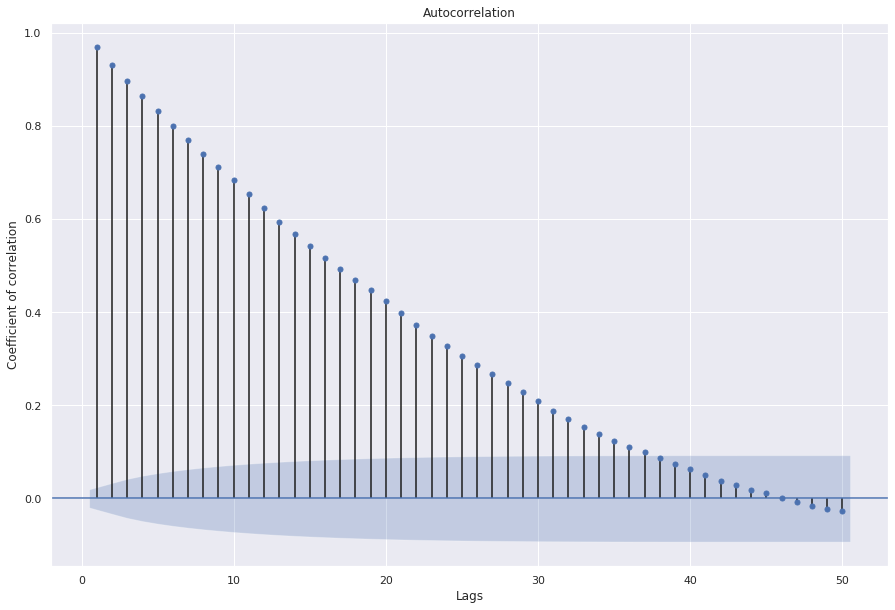

In [13]:
sgt.plot_acf(ts, lags=50, zero=False)
## We give zero=Flase since correlation of a time series with itself is always 1
plt.rc("figure", figsize=(15, 10))
plt.ylabel("Coefficient of correlation")
plt.xlabel("Lags")
plt.show()

- X axis represents the number of lags. 
- Y axis represents the correlation value of the time series with a lagged version of itself
- Blue area depicts significance. In this plot, all lines are higher than significance which means that all the autocorrelation coefficients are significant.
- Interpretation: There is time dependence in the data since we see high correlation. In other words, we can even use 50 points behind to predict what comes next.
- This curve is also indicative of some non-stationarity in the dataset. Although the dickey-fuller test shows stationarity, ACF plot with many significant coefficients may require integrations before modelling (explained in ARIMA section). 

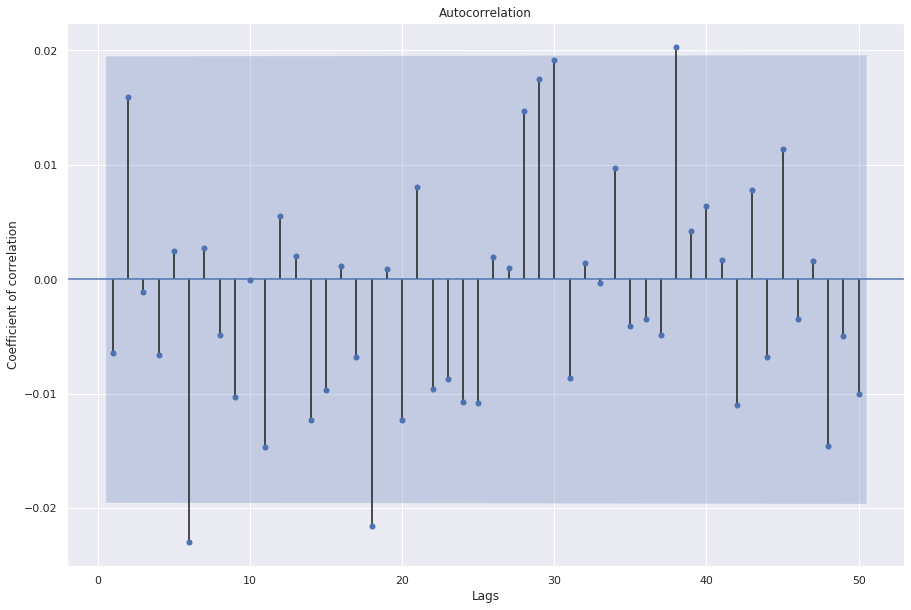

In [14]:
## Let's examine auto correlation of white noise
sgt.plot_acf(wn, lags=50, zero=False)
plt.rc("figure", figsize=(15, 10))
plt.ylabel("Coefficient of correlation")
plt.xlabel("Lags")
plt.show()

- We see that most coefficients are not significant 
- Randomly, some of them cross the blue area
- Hence, white noise has no auto correlation or no time dependence

#### PACF (Partial Auto correlation)
- Accounts for direct effect of x<sub>lagged</sub> on x<sub>t</sub>
- For example, ACF for a lag of 3, will also include effect of x<sub>t-3</sub> on x<sub>t-2</sub>, x<sub>t-2</sub> on x<sub>t-1</sub>, and x<sub>t-1</sub> on x<sub>t</sub>
- PACF for a lag of 3, only accounts for effect of x<sub>t-3</sub> on x<sub>t</sub>
- The first value is same for both as there are no indirect influences in the first computation.

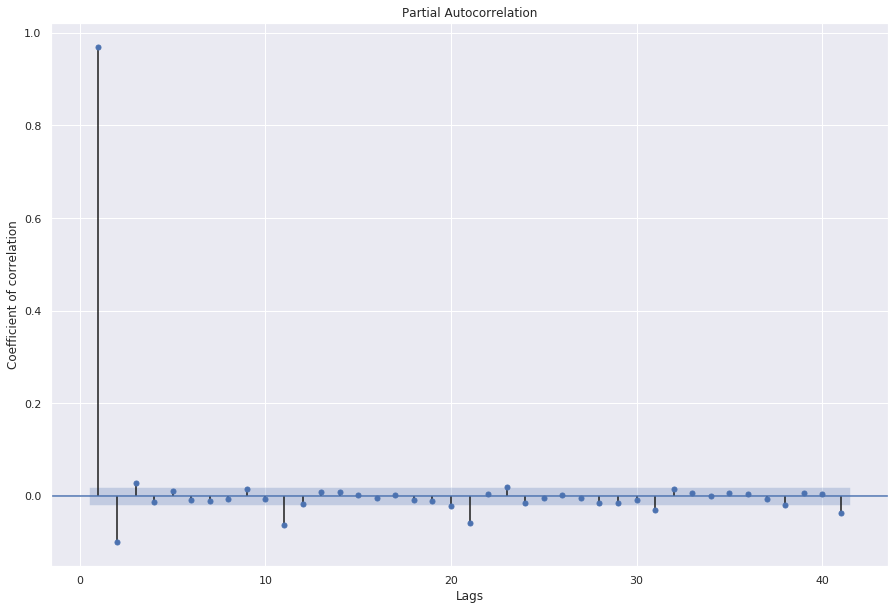

In [15]:
sgt.plot_pacf(ts, zero=False, method="ols")
plt.rc("figure", figsize=(15, 10))
plt.ylabel("Coefficient of correlation")
plt.xlabel("Lags")
plt.show()

Great! now we have a basic understanding of statistical properties of the time series data. Next, we'll look at how to model a time series data.

## Modelling 

Before we dive into various time series models, here are some general points to keep in mind:
- Start with a simple parsimonious model and add more parameters and complexity as required.
- If coefficients of added variables are significantly different from zero keep them otherwise prefer simpler models to favour generalizability.
- To see if we should select the more complex model, we can compare log likelihood, information criterion like AIC, and BIC. 
- Residuals: If the model fits the data well then the residuals should resemble white noise (or in other words, there is no trend left to capture).


### Auto regressive (AR) Model
The first model we will explore is the AR model. It is a linear model that learns from specified number of past observations. The following equation shows AR(1) or auto regression model that learns from just one past observation.

x<sub>t</sub> = c + $\phi$x<sub>t-1</sub> + $\epsilon$<sub>t</sub>


- $\phi$ is a numerical constant from -1 to 1 (otherwise it'll blow up)

- $\epsilon$<sub>t</sub> represents unpredictable shocks.

In real life, looking at just 1 lag may not give reasonable results. To determine the optimal number of lags, we look at PACF plots and incrementally increase the number.
If we have coefficients close to 1, that means they can be good candidates for the model.
Note: AR model stationary process better. For non-stationary time series, it is often converted to stationary process first.
    

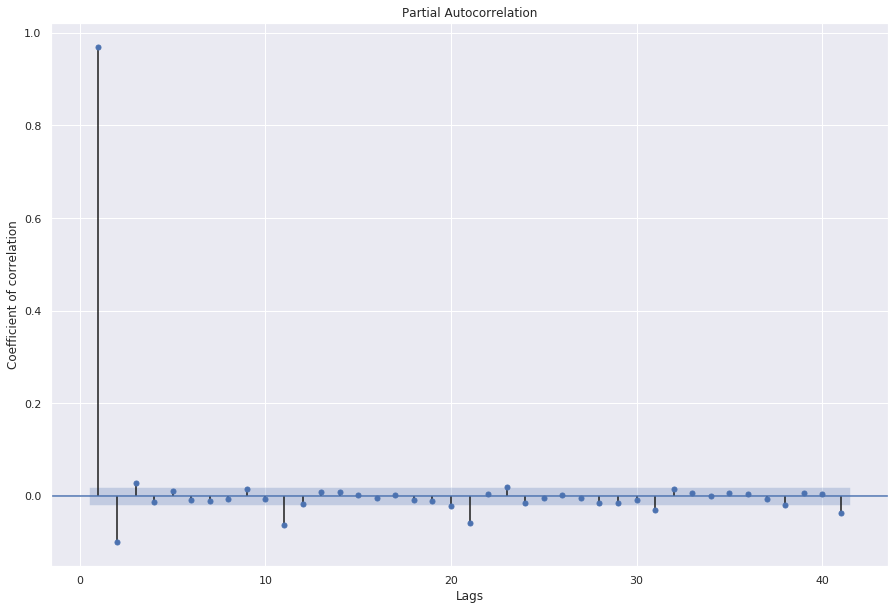

In [16]:
sgt.plot_pacf(ts, zero=False, method="ols")
plt.rc("figure", figsize=(15, 10))
plt.ylabel("Coefficient of correlation")
plt.xlabel("Lags")
plt.show()

In [17]:
## Let's start with a simple model with 1 lag
## Since we have the highest PACF coefficient for lag 1
model_ar_1 = ARMA(ts, order=(1, 0))
results_ar_1 = model_ar_1.fit()

In [18]:
results_ar_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  value   No. Observations:                10080
Model:                     ARMA(1, 0)   Log Likelihood             -182908.385
Method:                       css-mle   S.D. of innovations       18376741.625
Date:                Tue, 16 Feb 2021   AIC                         365822.770
Time:                        10:34:56   BIC                         365844.425
Sample:                    02-02-2021   HQIC                        365830.097
                         - 02-09-2021                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        8.412e+08   5.83e+06    144.363      0.000     8.3e+08    8.53e+08
ar.L1.value     0.9687      0.002    391.053      0.000       0.964       0.974
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0323           +0.0000j            1.0323            0.0000
-----------------------------------------------------------------------------
"""

Interpretation:
- ar.L1.value is the value of $\phi$ in the AR(1) equation. 
- const is the value of c in AR(1) equation.
- p < 0.05 suggests that these coefficients are significant.
- Since the ar.L1.value is not 0, this variable adds to the model.
- Great! let's increase the order and see if the more complex model is better.

In [19]:
model_ar_2 = ARMA(ts, order=(2, 0))
results_ar_2 = model_ar_2.fit()

In [20]:
results_ar_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  value   No. Observations:                10080
Model:                     ARMA(2, 0)   Log Likelihood             -182859.191
Method:                       css-mle   S.D. of innovations       18287258.874
Date:                Tue, 16 Feb 2021   AIC                         365726.383
Time:                        10:34:57   BIC                         365755.256
Sample:                    02-02-2021   HQIC                        365736.152
                         - 02-09-2021                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        8.412e+08   5.27e+06    159.483      0.000    8.31e+08    8.52e+08
ar.L1.value     1.0641      0.010    107.367      0.000       1.045       1.084
ar.L2.value    -0.0986      0.010     -9.943      0.000      -0.118      -0.079
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0399           +0.0000j            1.0399            0.0000
AR.2            9.7543           +0.0000j            9.7543            0.0000
-----------------------------------------------------------------------------
"""

Alright, we have a more complex model, but is it adding anything new? 
The log likelihood ratio (LLR) test determines if the new model adds value to the modelling significantly. It returns a p value, if p<0.05 then the complex model is better. 

In [21]:
# LLR Test
def llr_test(res_1, res_2, df=1):
    l1, l2 = res_1.llf, res_2.llf
    lr = 2 * (l2 - l1)
    p = chi2.sf(lr, df).round(3)
    result = "Insignificant"
    if p < 0.005:
        result = "Significant"
    return p, result


llr_test(results_ar_1, results_ar_2)

(0.0, 'Significant')

So the second model is significantly better than the first.

In [22]:
## Let's automate this process to find the order
llr = 0
p = 1
results = ARMA(ts, order=(p, 0)).fit()
while llr < 0.05:
    results_prev = results
    p += 1
    results = ARMA(ts, order=(p, 0)).fit()
    llr, _ = llr_test(results_prev, results)
    print(p, llr)

2 0.0
3 0.004
4 0.22


The above code suggests that going from order 3 to order 4 does not add any significant value in the model. We can also see that by looking at the summaries of the results. 
Side note: These are rules of thumb but as we see in the pacf plot, some higher lags than 3 are also significant, it could be that a higher lag model may fit the series better.

In [23]:
model_ar_3 = ARMA(ts, order=(3, 0))
results_ar_3 = model_ar_3.fit()

model_ar_4 = ARMA(ts, order=(4, 0))
results_ar_4 = model_ar_4.fit()

In [24]:
results_ar_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  value   No. Observations:                10080
Model:                     ARMA(3, 0)   Log Likelihood             -182855.084
Method:                       css-mle   S.D. of innovations       18279805.658
Date:                Tue, 16 Feb 2021   AIC                         365720.167
Time:                        10:35:00   BIC                         365756.259
Sample:                    02-02-2021   HQIC                        365732.379
                         - 02-09-2021                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        8.412e+08   5.43e+06    154.966      0.000    8.31e+08    8.52e+08
ar.L1.value     1.0670      0.010    107.170      0.000       1.047       1.086
ar.L2.value    -0.1290      0.015     -8.889      0.000      -0.157      -0.101
ar.L3.value     0.0285      0.010      2.867      0.004       0.009       0.048
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0375           -0.0000j            1.0375           -0.0000
AR.2            1.7397           -5.5441j            5.8106           -0.2016
AR.3            1.7397           +5.5441j            5.8106            0.2016
-----------------------------------------------------------------------------
"""

In [25]:
results_ar_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  value   No. Observations:                10080
Model:                     ARMA(4, 0)   Log Likelihood             -182854.332
Method:                       css-mle   S.D. of innovations       18278441.806
Date:                Tue, 16 Feb 2021   AIC                         365720.663
Time:                        10:35:01   BIC                         365763.973
Sample:                    02-02-2021   HQIC                        365735.318
                         - 02-09-2021                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        8.412e+08   5.36e+06    156.885      0.000    8.31e+08    8.52e+08
ar.L1.value     1.0673      0.010    107.169      0.000       1.048       1.087
ar.L2.value    -0.1305      0.015     -8.964      0.000      -0.159      -0.102
ar.L3.value     0.0416      0.015      2.855      0.004       0.013       0.070
ar.L4.value    -0.0122      0.010     -1.226      0.220      -0.032       0.007
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0385           -0.0000j            1.0385           -0.0000
AR.2            4.4697           -0.0000j            4.4697           -0.0000
AR.3           -1.0523           -4.0655j            4.1995           -0.2903
AR.4           -1.0523           +4.0655j            4.1995            0.2903
-----------------------------------------------------------------------------
"""

At the end the more complex model should have both insignificant $\phi$ values and insignificant log value. When we reach that stage, in this case at the lag 3, we stop. 

Side note: If you want to compare different time series, make sure to normalize values. One way to do this is to divide the series by the first number.

#### Analyzing the residuals
- This is a very important step in analysing the model performance.
- Remember that residuals should be similar to white noise reflecting that there is no trend remaining to be captured.
- We will now plot the residuals, check for stationarity, and check ACF plots.

In [26]:
resid = results_ar_3.resid

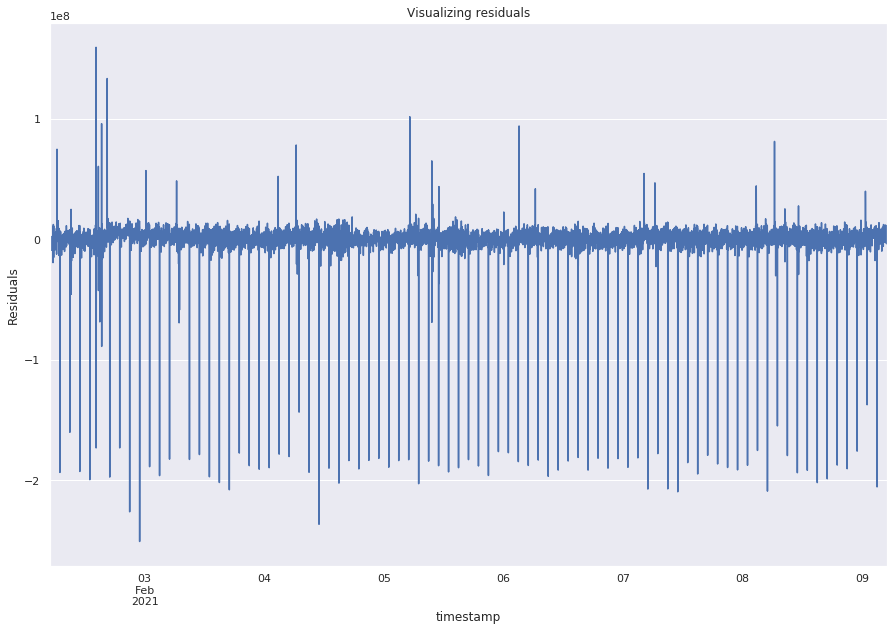

In [27]:
resid.plot()
plt.ylabel("Residuals")
plt.rc("figure", figsize=(15, 10))
plt.title("Visualizing residuals")
plt.show()

In [28]:
print(resid.mean(), resid.var())

9857.74948797849 335785710909501.9


In [29]:
adfuller(resid)

(-20.713996039693797,
 0.0,
 21,
 10058,
 {'1%': -3.4310003250850523,
  '5%': -2.8618274051853487,
  '10%': -2.5669229806403036},
 364247.3069721225)

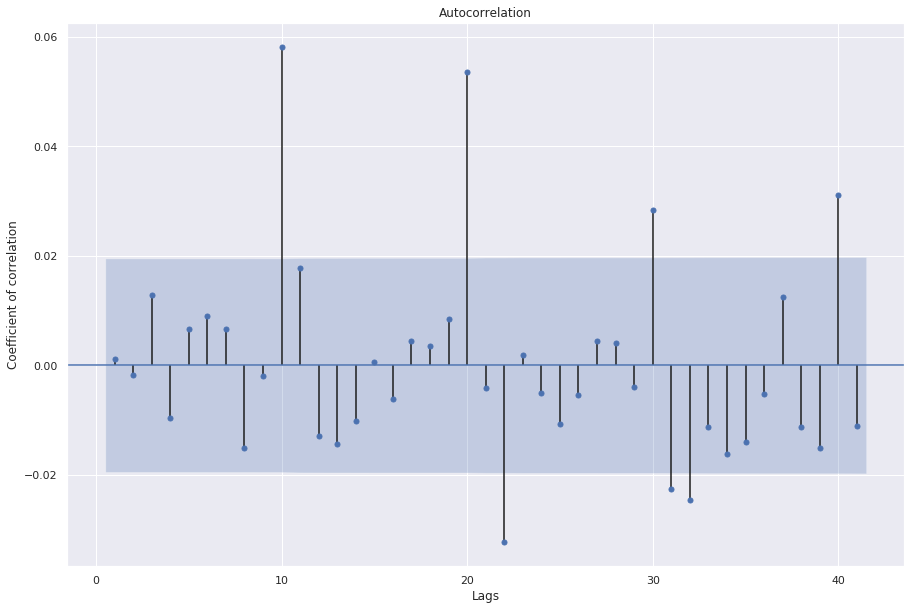

In [30]:
sgt.plot_acf(resid, zero=False)
plt.rc("figure", figsize=(15, 10))
plt.ylabel("Coefficient of correlation")
plt.xlabel("Lags")
plt.show()

#### Interpretation
- The plot shows that the residuals look random but are not exactly like white noise.
- The Dickey Fuller test suggests that the residuals are stationary.
- The ACF plots show coefficients that are significant further indicating that the residuals are not perfectly white noise and there could be better predictors.

### Moving average model 

- Better suited if the data has unexpected shocks
- Accounts for the past residuals
- Absorbs shocks (accounts from past errors) and correct 

r<sub>t</sub> = c + $\theta$$\epsilon$<sub>t-1</sub> + $\epsilon$<sub>t</sub> 


- For finding the optimal number of lags for this model, we rely more on ACF than PACF because it learns from residuals, so the direct effect of a past observation on the present day is not relevant.
- Mathematical fact: If MA coefficients are close to 1 then it is basically an approximation of AR model.
- Both AR, MA models are bad with non-stationary data.

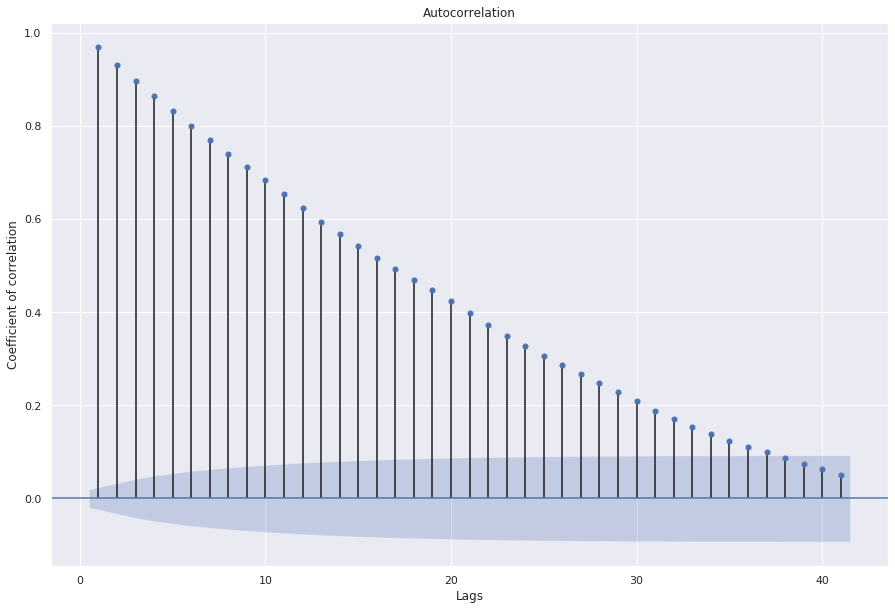

In [31]:
sgt.plot_acf(ts, zero=False)
plt.rc("figure", figsize=(15, 10))
plt.ylabel("Coefficient of correlation")
plt.xlabel("Lags")
plt.show()

Most the coefficients in the lags are significant implying that MA(n+1) will always be better than MA(n). This type of data suggests that some type of a combination of AR and MA is required to correctly model the data. For reference, let's train a MA model of order 1. 

#### model_ma_1 = ARMA(ts, order=(0, 1))  ## p, q where p is AR and q is MA param
model_ma_results_1 = ARMA(ts, order=(0, 1)).fit()
model_ma_results_1.summary()

The results show that the coefficient is significant.

## ARMA (AR and MA models together)

- The ARMA model considers both lagged value and lagged errors.
- Following equation represents ARMA(1,1):

r<sub>t</sub> = c + $\phi$r<sub>t-1</sub> + $\theta$$\epsilon$<sub>t-1</sub> + $\epsilon$<sub>t</sub>

- For ARMA model, we select complex model and move to simpler models.
- For determining p, q take hint from PACF and ACF respectively.
- The  coefficients of the complex model should be significantly better than 0 and the either the AIC should be lower or the LLR test should give significant p-values.
- LLR test only works for nested models (one model should have all the lag terms of the other). While comparing ARMA(1,3) and ARMA(3,1), we have to look at AIC. Lower values of AIC are prefered over higher values.


- In this case, let's start with 4,4 as we found 3 lags for AR component and MA can be anything.

In [33]:
model_arma_44 = ARMA(ts, order=(4, 4))  ## p, q where p is AR and q is MA param
model_arma_results_44 = model_arma_44.fit()
model_arma_results_44.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  value   No. Observations:                10080
Model:                     ARMA(4, 4)   Log Likelihood             -182733.562
Method:                       css-mle   S.D. of innovations                nan
Date:                Tue, 16 Feb 2021   AIC                         365487.124
Time:                        10:35:34   BIC                         365559.307
Sample:                    02-02-2021   HQIC                        365511.548
                         - 02-09-2021                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        8.412e+08     20.982   4.01e+07      0.000    8.41e+08    8.41e+08
ar.L1.value     2.8314        nan        nan        nan         nan         nan
ar.L2.value    -2.5551        nan        nan        nan         nan         nan
ar.L3.value     0.6128   1.53e-06      4e+05      0.000       0.613       0.613
ar.L4.value     0.1108   1.49e-06   7.46e+04      0.000       0.111       0.111
ma.L1.value    -1.7883        nan        nan        nan         nan         nan
ma.L2.value     0.5609      0.000   4789.722      0.000       0.561       0.561
ma.L3.value     0.2530   9.77e-05   2590.521      0.000       0.253       0.253
ma.L4.value    -0.0225        nan        nan        nan         nan         nan
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.9987           -0.0524j            1.0001           -0.0083
AR.2            0.9987           +0.0524j            1.0001            0.0083
AR.3            1.0517           -0.0000j            1.0517           -0.0000
AR.4           -8.5793           -0.0000j            8.5793           -0.5000
MA.1            0.9991           -0.0512j            1.0004           -0.0081
MA.2            0.9991           +0.0512j            1.0004            0.0081
MA.3           -3.4868           -0.0000j            3.4868           -0.5000
MA.4           12.7289           -0.0000j           12.7289           -0.0000
-----------------------------------------------------------------------------
"""

We see some insignificant nan values. Let's try lesser orders than 4,4.

In [34]:
p = range(1, 5)
q = range(1, 5)
pq = list(itertools.product(p, q))
for i in range(1, len(pq)):
    print("Model: {}".format(pq[i]))

Model: (1, 2)
Model: (1, 3)
Model: (1, 4)
Model: (2, 1)
Model: (2, 2)
Model: (2, 3)
Model: (2, 4)
Model: (3, 1)
Model: (3, 2)
Model: (3, 3)
Model: (3, 4)
Model: (4, 1)
Model: (4, 2)
Model: (4, 3)
Model: (4, 4)


In [35]:
results = []
for order in pq:
    try:
        print(order)
        model_arma_results = ARMA(ts, order=order).fit()
        results.append([order, model_arma_results.aic])
    except ValueError as e:
        print(order, "Error", e)
        results.append([order, float("inf")])

(1, 1)
(1, 2)
(1, 3)
(1, 4)
(2, 1)
(2, 2)
(2, 2) Error The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
(2, 3)
(2, 3) Error The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
(2, 4)
(2, 4) Error The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
(3, 1)
(3, 2)
(3, 3)
(3, 4)
(3, 4) Error The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
(4, 1)
(4, 2)
(4, 3)
(4, 4)


In [36]:
results.sort(key=lambda x: x[1])
results

[[(4, 4), 365487.1237348594],
 [(3, 3), 365487.3044743438],
 [(4, 3), 365590.6216117728],
 [(2, 1), 365718.12121550634],
 [(1, 2), 365718.93765811616],
 [(3, 1), 365719.5192103497],
 [(1, 3), 365720.09677658137],
 [(1, 1), 365721.14203969063],
 [(1, 4), 365721.4326000532],
 [(4, 1), 365721.5065082582],
 [(3, 2), 365721.51111814147],
 [(4, 2), 365723.4880829039],
 [(2, 2), inf],
 [(2, 3), inf],
 [(2, 4), inf],
 [(3, 4), inf]]

In [37]:
model_arma_43_results = ARMA(ts, order=(4, 3)).fit()
model_arma_43_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  value   No. Observations:                10080
Model:                     ARMA(4, 3)   Log Likelihood             -182786.311
Method:                       css-mle   S.D. of innovations       18153981.434
Date:                Tue, 16 Feb 2021   AIC                         365590.622
Time:                        10:39:34   BIC                         365655.586
Sample:                    02-02-2021   HQIC                        365612.603
                         - 02-09-2021                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        8.412e+08   5.41e+06    155.365      0.000    8.31e+08    8.52e+08
ar.L1.value     0.8821      0.083     10.674      0.000       0.720       1.044
ar.L2.value    -0.7895      0.104     -7.591      0.000      -0.993      -0.586
ar.L3.value     0.4840      0.104      4.664      0.000       0.281       0.687
ar.L4.value     0.3398      0.078      4.336      0.000       0.186       0.493
ma.L1.value     0.1843      0.079      2.326      0.020       0.029       0.340
ma.L2.value     0.8717      0.022     40.394      0.000       0.829       0.914
ma.L3.value     0.4525      0.079      5.739      0.000       0.298       0.607
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0377           -0.0000j            1.0377           -0.0000
AR.2            0.1452           -1.0047j            1.0151           -0.2272
AR.3            0.1452           +1.0047j            1.0151            0.2272
AR.4           -2.7521           -0.0000j            2.7521           -0.5000
MA.1            0.1360           -0.9934j            1.0026           -0.2283
MA.2            0.1360           +0.9934j            1.0026            0.2283
MA.3           -2.1982           -0.0000j            2.1982           -0.5000
-----------------------------------------------------------------------------
"""

In [59]:
model_arma_33_results = ARMA(ts, order=(3, 3)).fit()
model_arma_33_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  value   No. Observations:                10080
Model:                     ARMA(3, 3)   Log Likelihood             -182735.652
Method:                       css-mle   S.D. of innovations       18059726.935
Date:                Tue, 16 Feb 2021   AIC                         365487.304
Time:                        10:49:24   BIC                         365545.051
Sample:                    02-02-2021   HQIC                        365506.844
                         - 02-09-2021                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        8.412e+08   5.37e+06    156.737      0.000    8.31e+08    8.52e+08
ar.L1.value     0.3448      0.003    114.756      0.000       0.339       0.351
ar.L2.value    -0.4047      0.002   -217.054      0.000      -0.408      -0.401
ar.L3.value     0.9627      0.003    320.713      0.000       0.957       0.969
ma.L1.value     0.7298      0.010     70.009      0.000       0.709       0.750
ma.L2.value     1.0672      0.006    164.351      0.000       1.054       1.080
ma.L3.value     0.1094      0.010     10.494      0.000       0.089       0.130
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.3091           -0.9511j            1.0001           -0.3000
AR.2           -0.3091           +0.9511j            1.0001            0.3000
AR.3            1.0385           -0.0000j            1.0385           -0.0000
MA.1           -0.3103           -0.9510j            1.0004           -0.3002
MA.2           -0.3103           +0.9510j            1.0004            0.3002
MA.3           -9.1298           -0.0000j            9.1298           -0.5000
-----------------------------------------------------------------------------
"""

Here we see all coefficients are not significant except for ARMA(4,4) which has the lowest AIC. ARMA(4,3) and ARMA(3,3) have low AIC, with all significant coefficients. Both of these models are good candidates for fitting the series.

#### Analyzing the residuals

In [39]:
resid_43 = model_arma_43_results.resid

Text(0.5, 1.0, 'Visualizing residuals')

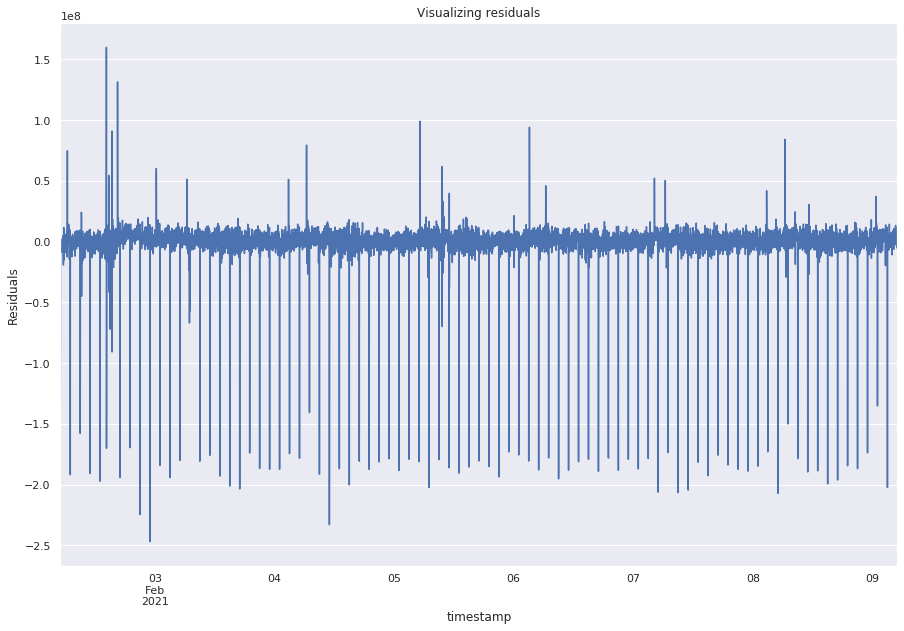

In [40]:
resid_43.plot()
plt.ylabel("Residuals")
plt.rc("figure", figsize=(15, 10))
plt.title("Visualizing residuals")

In [41]:
adfuller(resid_43)

(-17.905681410226855,
 2.9421969683091178e-30,
 32,
 10047,
 {'1%': -3.4310010372782322,
  '5%': -2.8618277198980784,
  '10%': -2.5669231481622323},
 364128.4984193336)

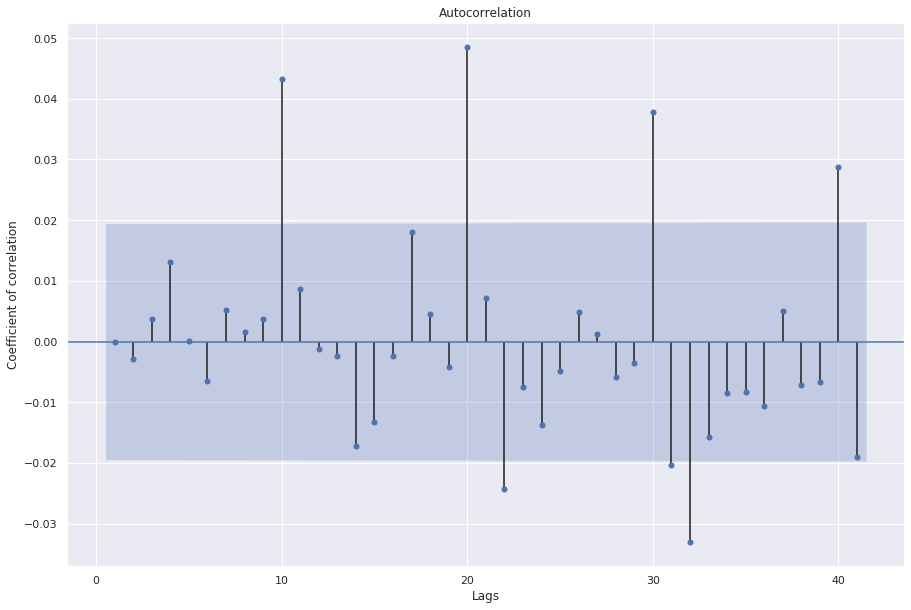

In [42]:
sgt.plot_acf(resid_43, zero=False)
plt.rc("figure", figsize=(15, 10))
plt.ylabel("Coefficient of correlation")
plt.xlabel("Lags")
plt.show()

- This plot has are several significant values in the PACF.
- We can train higher order ARMA models but usually we have to go for ARIMA models.

### [ARIMA](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average) models
- Auto-regressive integrated moving average model.
- Since ARMA models do not work well with non-stationary data, we introduce integrations to make the data the stationary.
- The model builds on the difference between the time periods (integerated values) instead of the values itself.
- For example, converting prices to returns in stock market data would be similar to 1 degree of integration.
- Intuitively, modelling returns instead of prices may be better since returns may resemble stationary data.
- ARIMA has p, d, q hyperparameters.
- d -> number of degree of changes to ensure stationarity.
- One way of finding d is to compute delta of the data unitll stationarity is found.
- ARIMA method uses AIC criteria to compare models with different orders.
- The following equation represents ARIMA(1,1,1).
- Start from a simple model and increase orders by looking at residuals.

$\Delta$P<sub>t</sub> = c + $\phi$$\Delta$P<sub>t-1</sub> + $\theta$$\epsilon$<sub>t-1</sub> + $\epsilon$<sub>t</sub>


In [43]:
arima_111 = ARIMA(ts, order=(1, 1, 1)).fit()

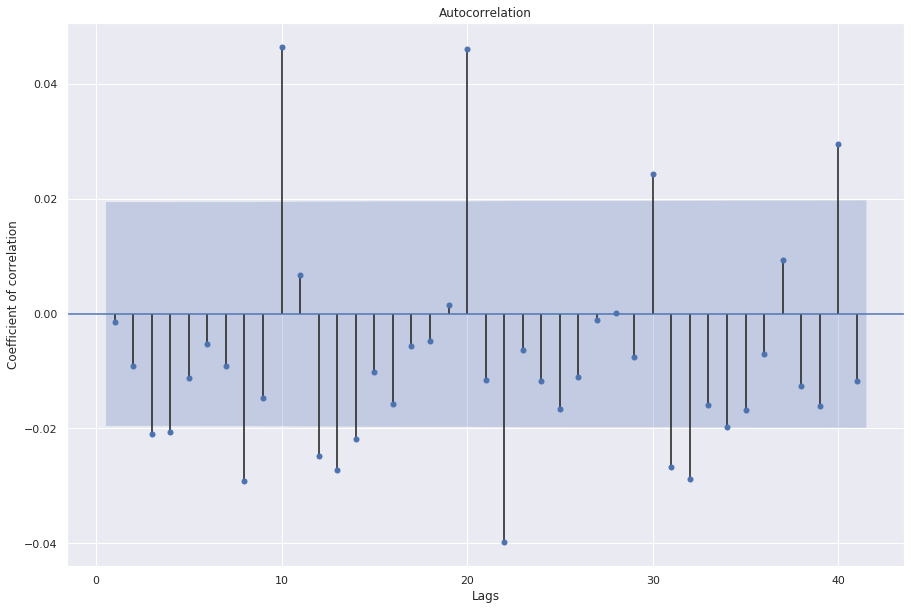

In [44]:
sgt.plot_acf(arima_111.resid, zero=False)
plt.rc("figure", figsize=(15, 10))
plt.ylabel("Coefficient of correlation")
plt.xlabel("Lags")
plt.show()

We see that the third lag is significant. We can try all models from ARIMA(0,0,0) to ARIMA(3,1,3).

In [45]:
p = range(0, 4)
d = range(0, 2)
q = range(0, 4)
pdq = list(itertools.product(p, d, q))
for i in range(1, len(pdq)):
    print("Model: {}".format(pdq[i]))

results = []
for order in pdq:
    try:
        print(order)
        model_arima_results = ARIMA(ts, order=order).fit()
        results.append([order, model_arima_results.aic])
    except ValueError as e:
        print(order, "Error", e)
        results.append([order, float("inf")])

Model: (0, 0, 1)
Model: (0, 0, 2)
Model: (0, 0, 3)
Model: (0, 1, 0)
Model: (0, 1, 1)
Model: (0, 1, 2)
Model: (0, 1, 3)
Model: (1, 0, 0)
Model: (1, 0, 1)
Model: (1, 0, 2)
Model: (1, 0, 3)
Model: (1, 1, 0)
Model: (1, 1, 1)
Model: (1, 1, 2)
Model: (1, 1, 3)
Model: (2, 0, 0)
Model: (2, 0, 1)
Model: (2, 0, 2)
Model: (2, 0, 3)
Model: (2, 1, 0)
Model: (2, 1, 1)
Model: (2, 1, 2)
Model: (2, 1, 3)
Model: (3, 0, 0)
Model: (3, 0, 1)
Model: (3, 0, 2)
Model: (3, 0, 3)
Model: (3, 1, 0)
Model: (3, 1, 1)
Model: (3, 1, 2)
Model: (3, 1, 3)
(0, 0, 0)
(0, 0, 1)
(0, 0, 2)
(0, 0, 2) Error The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
(0, 0, 3)
(0, 0, 3) Error The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
(0, 1, 0)
(0, 1, 1)
(0, 1, 2)
(0, 1, 3)
(1, 0, 0)
(1, 0, 1)
(1, 0, 2)
(1, 0, 3)
(

In [46]:
results.sort(key=lambda x: x[1])
results

[[(3, 0, 3), 365487.3044743438],
 [(3, 1, 2), 365690.83679202065],
 [(3, 1, 1), 365691.87849008595],
 [(1, 1, 2), 365691.92489622836],
 [(2, 1, 1), 365696.89234614855],
 [(2, 0, 1), 365718.12121550634],
 [(1, 0, 2), 365718.93765811616],
 [(3, 0, 1), 365719.5192103497],
 [(1, 0, 3), 365720.09677658137],
 [(3, 0, 0), 365720.1672000957],
 [(1, 0, 1), 365721.14203969063],
 [(3, 0, 2), 365721.51111814147],
 [(2, 0, 0), 365726.38260047237],
 [(1, 0, 0), 365822.770154617],
 [(2, 1, 0), 365854.88895507844],
 [(0, 1, 2), 365854.9773183209],
 [(0, 1, 3), 365856.0842035335],
 [(3, 1, 0), 365856.5834094851],
 [(1, 1, 1), 365857.4704805023],
 [(0, 1, 1), 365868.8083093382],
 [(1, 1, 0), 365875.05135895085],
 [(0, 1, 0), 365939.7623796054],
 [(0, 0, 1), 382895.5433298524],
 [(0, 0, 0), 393845.016979624],
 [(0, 0, 2), inf],
 [(0, 0, 3), inf],
 [(1, 1, 3), inf],
 [(2, 0, 2), inf],
 [(2, 0, 3), inf],
 [(2, 1, 2), inf],
 [(2, 1, 3), inf],
 [(3, 1, 3), inf]]

In [60]:
ARIMA(ts, order=(3, 0, 3)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  value   No. Observations:                10080
Model:                     ARMA(3, 3)   Log Likelihood             -182735.652
Method:                       css-mle   S.D. of innovations       18059726.935
Date:                Tue, 16 Feb 2021   AIC                         365487.304
Time:                        11:25:32   BIC                         365545.051
Sample:                    02-02-2021   HQIC                        365506.844
                         - 02-09-2021                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        8.412e+08   5.37e+06    156.737      0.000    8.31e+08    8.52e+08
ar.L1.value     0.3448      0.003    114.756      0.000       0.339       0.351
ar.L2.value    -0.4047      0.002   -217.054      0.000      -0.408      -0.401
ar.L3.value     0.9627      0.003    320.713      0.000       0.957       0.969
ma.L1.value     0.7298      0.010     70.009      0.000       0.709       0.750
ma.L2.value     1.0672      0.006    164.351      0.000       1.054       1.080
ma.L3.value     0.1094      0.010     10.494      0.000       0.089       0.130
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.3091           -0.9511j            1.0001           -0.3000
AR.2           -0.3091           +0.9511j            1.0001            0.3000
AR.3            1.0385           -0.0000j            1.0385           -0.0000
MA.1           -0.3103           -0.9510j            1.0004           -0.3002
MA.2           -0.3103           +0.9510j            1.0004            0.3002
MA.3           -9.1298           -0.0000j            9.1298           -0.5000
-----------------------------------------------------------------------------
"""

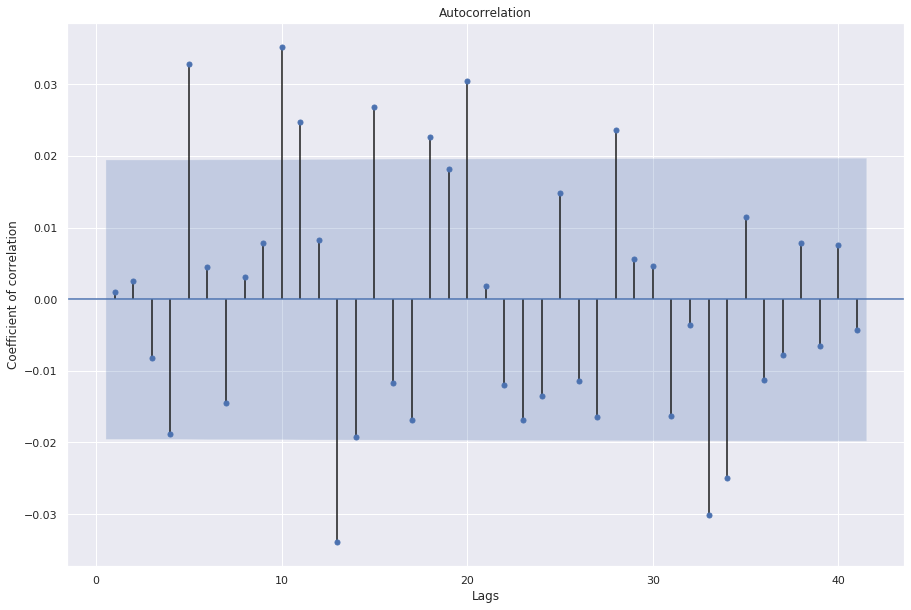

In [61]:
sgt.plot_acf(ARIMA(ts, order=(3, 0, 3)).fit().resid, zero=False)
plt.rc("figure", figsize=(15, 10))
plt.ylabel("Coefficient of correlation")
plt.xlabel("Lags")
plt.show()

Great, we see that the first 4 coefficients are now not significant. At this point, as an additional exercise, we could try models with lag 5,6, and 7 as well to further improve performance. 
Next, we are going to look at how to select the value for "d", or the number of integrations required for modelling the data. Remember that integrations are done to introduce stationarity and should be avoided if the data is already stationary. In this case, the adfuller test says that the data is stationary but ACF plot shows many significant correlations. Hence we try d as 1. Let's manually compute 1 degree of integration and check stationarity.

In [62]:
adfuller(ts.diff(1)[1:])

(-19.127626021632565,
 0.0,
 39,
 10039,
 {'1%': -3.431001556217458,
  '5%': -2.861827949213313,
  '10%': -2.5669232702269893},
 364359.1091279416)

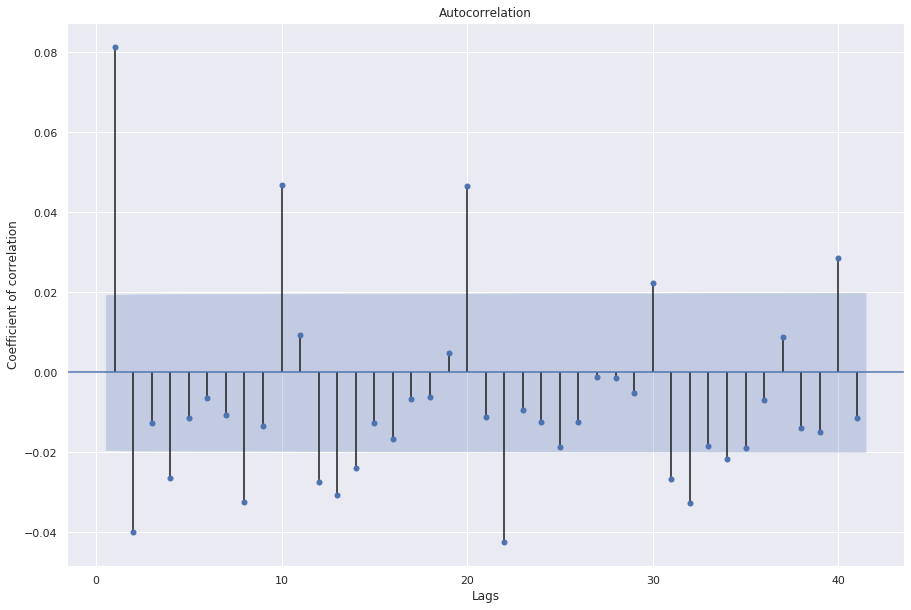

In [63]:
sgt.plot_acf(ts.diff(1)[1:], zero=False)
plt.rc("figure", figsize=(15, 10))
plt.ylabel("Coefficient of correlation")
plt.xlabel("Lags")
plt.show()

Cool, the ACF plot has less significant correlations and the adfuller test also indicates that after one integration the data is stationarity.
For exercise, and a rigorous search for the best model, we could check for models with d=2 as well. However, we prefer simpler models over complex models if the improvements are not significant. Let's fit ARIMA(3,1,2) and evaluate the results.

In [64]:
ARIMA_312 = ARIMA(ts, order=(3, 1, 2)).fit()
ARIMA_312.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.value   No. Observations:                10079
Model:                 ARIMA(3, 1, 2)   Log Likelihood             -182838.418
Method:                       css-mle   S.D. of innovations       18283795.466
Date:                Tue, 16 Feb 2021   AIC                         365690.837
Time:                        11:51:26   BIC                         365741.364
Sample:                    02-02-2021   HQIC                        365707.933
                         - 02-09-2021                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          2.508e+04    2.5e+04      1.004      0.316   -2.39e+04     7.4e+04
ar.L1.D.value     0.5302      0.199      2.669      0.008       0.141       0.920
ar.L2.D.value     0.4384      0.215      2.043      0.041       0.018       0.859
ar.L3.D.value    -0.0270      0.026     -1.041      0.298      -0.078       0.024
ma.L1.D.value    -0.4620      0.198     -2.331      0.020      -0.851      -0.073
ma.L2.D.value    -0.5331      0.197     -2.699      0.007      -0.920      -0.146
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0435           +0.0000j            1.0435            0.0000
AR.2           -2.0575           +0.0000j            2.0575            0.5000
AR.3           17.2544           +0.0000j           17.2544            0.0000
MA.1            1.0032           +0.0000j            1.0032            0.0000
MA.2           -1.8698           +0.0000j            1.8698            0.5000
-----------------------------------------------------------------------------
"""

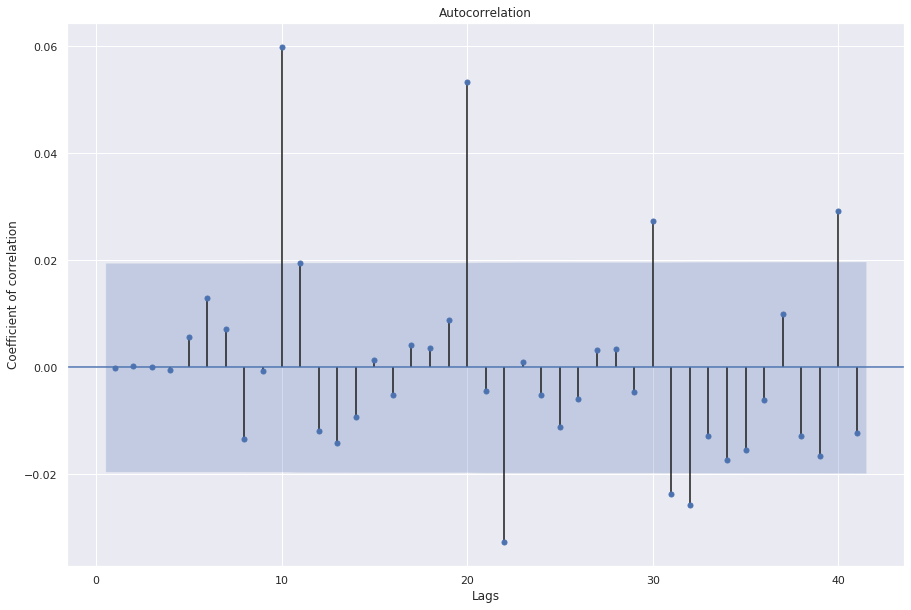

In [65]:
sgt.plot_acf(ARIMA_312.resid, zero=False)
plt.rc("figure", figsize=(15, 10))
plt.ylabel("Coefficient of correlation")
plt.xlabel("Lags")
plt.show()

Cool, we see 9 insignificant coefficients indicating that this model is a good choice.

## ARIMAX (Exogenous factors)

In addition to past observations, sometimes external factors also affect the future value of a time series

$\Delta$P<sub>t</sub> = c + $\beta$X + $\phi$$\Delta$P<sub>t-1</sub> + $\theta$$\epsilon$<sub>t-1</sub> + $\epsilon$<sub>t</sub>

- X can be anything (data should be available for each period).
- E.g. S&P prices for predicting a particular stock price.
- $\beta$ is a fitted coefficient.

## SARIMAX (Seasonality)
Some time series have a seasonal aspect to them. For example, consider the number of views for a christmas song every month. Every year in December we can expect a spike in the series.
- SARIMAX model includes a lag term for the last period.
- Hyper parameters of SARIMAX: (p,d,q)(P,D,Q,s).
- (p,d,q) is the ARIMA order.
- 's' signifies how far behind do we observe the seasonal affect; s=1 means no seasonality.
- In our number of songs example, the value of s will be 12.
- P, Q specifies how many seasonal AR and MA terms we will have so for s=12, P=2, Q=1, the equation will have y<sub>t-12</sub>,  y<sub>t-24</sub>, and $\epsilon$<sub>t-12</sub>
- D specifies seasonal integrations.
- The total number of coefficients for the model will be: P + Q + p + q coeffs.
- In our current example we don't see any seasonality but let's train a SARIMAX model to understand how it works.

In [51]:
model_sarimax = SARIMAX(
    ts, exog=wn, order=(3, 1, 1), seasonal_order=(2, 0, 1, 5)
).fit()

In [52]:
model_sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             value   No. Observations:                10080
Model:             SARIMAX(3, 1, 1)x(2, 0, 1, 5)   Log Likelihood             -182922.361
Date:                           Tue, 16 Feb 2021   AIC                         365862.721
Time:                                   10:43:29   BIC                         365927.685
Sample:                               02-02-2021   HQIC                        365884.702
                                    - 02-09-2021                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0030      0.002     -1.892      0.058      -0.006       0.000
ar.L1          0.0335      6.123      0.005      0.996     -11.968      12.035
ar.L2         -0.0346      0.431     -0.080      0.936      -0.879       0.810
ar.L3         -0.0054      0.238     -0.022      0.982      -0.473       0.462
ma.L1          0.0367      6.123      0.006      0.995     -11.964      12.037
ar.S.L5        0.1156      0.632      0.183      0.855      -1.124       1.355
ar.S.L10       0.0393      0.014      2.831      0.005       0.012       0.066
ma.S.L5       -0.1237      0.635     -0.195      0.846      -1.369       1.122
sigma2        3.4e+14   3.64e-11   9.35e+24      0.000     3.4e+14     3.4e+14
===================================================================================
Ljung-Box (L1) (Q):                   1.96   Jarque-Bera (JB):           4203838.79
Prob(Q):                              0.16   Prob(JB):                         0.00
Heteroskedasticity (H):               0.90   Skew:                            -9.24
Prob(H) (two-sided):                  0.00   Kurtosis:                       101.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.86e+38. Standard errors may be unstable.
"""

## Automated 
- In the final section of this notebook, we show the use of auto_arima function of [pmdarima](https://alkaline-ml.com/pmdarima/modules/classes.html) library that automatically finds hyperparameters for a SARIMAX model.
- However, we need to proceed with caution and do our due diligence before selecting a new model as automated values may choose a complicated model but in real life we may prefer a simpler one.
- The function does dickey fuller test to find d; and uses one information criteria to select between models (default being "aic").
- The function does not look at whether all coefficients are significant or not, we have to consider that on our own.

In [53]:
## Calling auto arima with default settings
auto_arima_model = auto_arima(ts)

In [54]:
auto_arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                10080
Model:               SARIMAX(2, 1, 3)   Log Likelihood             -182891.981
Date:                Tue, 16 Feb 2021   AIC                         365797.962
Time:                        10:47:16   BIC                         365848.489
Sample:                             0   HQIC                        365815.058
                              - 10080                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   2.587e+04   1.57e+04      1.645      0.100   -4945.649    5.67e+04
ar.L1          0.0825      0.428      0.193      0.847      -0.756       0.921
ar.L2          0.8286      0.401      2.065      0.039       0.042       1.615
ma.L1         -0.0225      0.427     -0.053      0.958      -0.860       0.815
ma.L2         -0.8740      0.370     -2.362      0.018      -1.599      -0.149
ma.L3         -0.0758      0.050     -1.521      0.128      -0.174       0.022
sigma2        3.4e+14   7.37e-05   4.62e+18      0.000     3.4e+14     3.4e+14
===================================================================================
Ljung-Box (L1) (Q):                   1.94   Jarque-Bera (JB):           4014680.84
Prob(Q):                              0.16   Prob(JB):                         0.00
Heteroskedasticity (H):               0.89   Skew:                            -9.07
Prob(H) (two-sided):                  0.00   Kurtosis:                        99.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.99e+32. Standard errors may be unstable.
"""

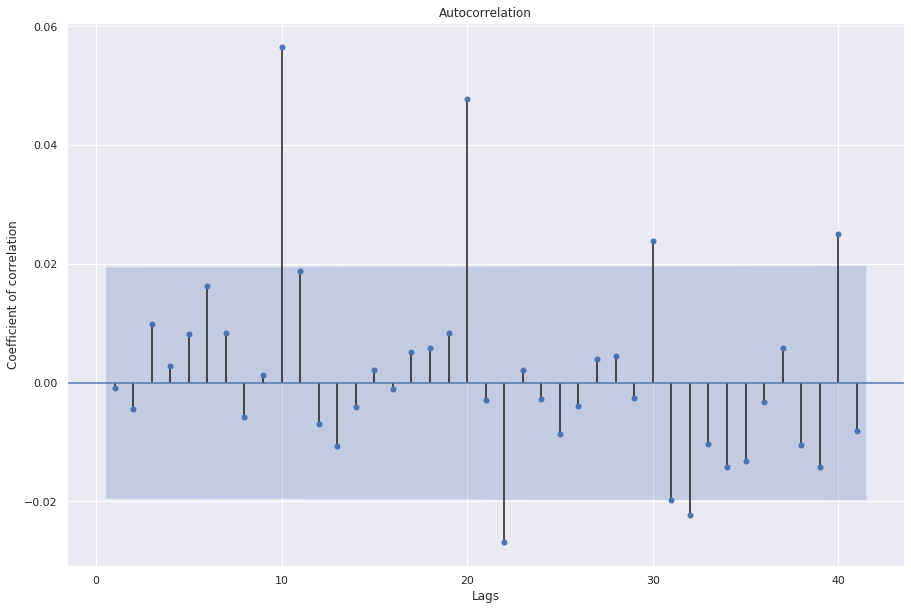

In [55]:
## Evaluating residuals
sgt.plot_acf(auto_arima_model.resid(), zero=False)
plt.rc("figure", figsize=(15, 10))
plt.ylabel("Coefficient of correlation")
plt.xlabel("Lags")
plt.show()

- Here we see the auto_arima selects an ARIMA model with order 2,1,3. In our manual analysis using statsmodel package, the model with 2,1,3 could not converge. We can make changes to the default parameters to the function to give it more information.
- An important information criteria is oob which selects model based on the score performance of the model on a validation set. Let's try that.

In [56]:
## The commented parameters can be uncommented based on the need.

aam = auto_arima(
    ts,
    #            exogenous=,
    #            m=12, SARIMAX s
    max_order=None,
    max_p=6,  # Search till p=6
    max_q=6,  # Search till q=6
    max_d=2,  # Search till d=2
    #            max_P= #Search till P=2
    #            max_Q= #Search till Q=2
    #            max_D= #Search till D=2
    maxiter=50,  # Increase if you see no convergence
    njobs=-1,  # Number of parallel processes
    #           trend="ct", ##ctt for quadratic; accounts for trend in data
    information_criterion="oob",  # out of bag aic, aicc, bic, hqic
    out_of_sample_size=int(len(ts) * 0.2),  ## Validation set of 20% for oob
)

In [57]:
aam.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                10080
Model:               SARIMAX(1, 1, 0)   Log Likelihood             -182942.835
Date:                Tue, 16 Feb 2021   AIC                         365891.670
Time:                        10:47:47   BIC                         365913.324
Sample:                             0   HQIC                        365898.997
                              - 10080                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   7711.9077   8.06e-12   9.57e+14      0.000    7711.908    7711.908
ar.L1          0.0669      0.005     12.802      0.000       0.057       0.077
sigma2      3.476e+14   1.08e-18    3.2e+32      0.000    3.48e+14    3.48e+14
===================================================================================
Ljung-Box (L1) (Q):                   3.05   Jarque-Bera (JB):           4207310.37
Prob(Q):                              0.08   Prob(JB):                         0.00
Heteroskedasticity (H):               0.90   Skew:                            -9.25
Prob(H) (two-sided):                  0.00   Kurtosis:                       101.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.35e+40. Standard errors may be unstable.
"""

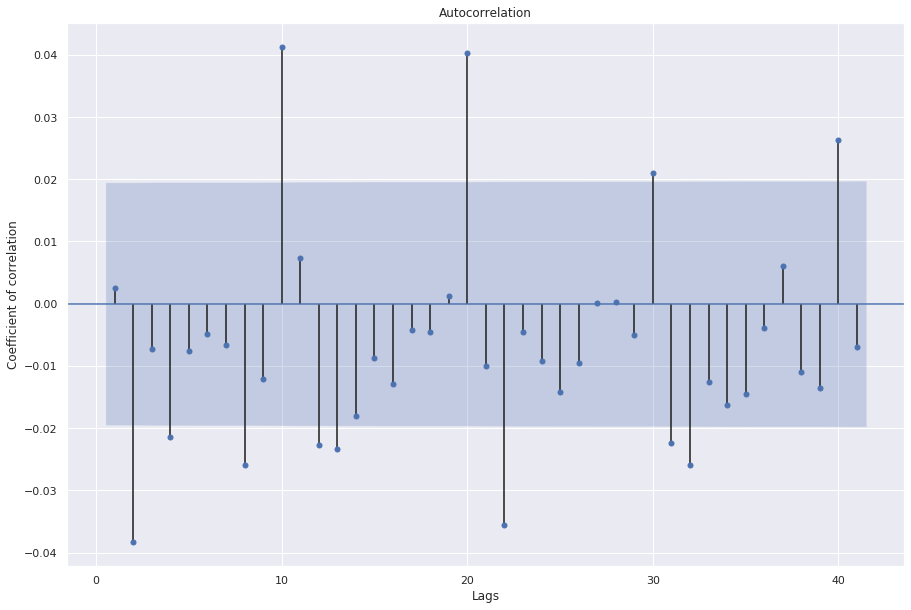

In [58]:
sgt.plot_acf(aam.resid(), zero=False)
plt.rc("figure", figsize=(15, 10))
plt.ylabel("Coefficient of correlation")
plt.xlabel("Lags")
plt.show()

With updated parameters, especially the information criterion as "oob" we see the function selects an inferior model in terms of AIC and significance of the coefficients. However this model performs well on the validation set. We need to conduct further experiments with a test set to find the generalizability of these models.

# Conclusion
Awesome! Apologies for a really long notebook, but we have learnt how to understand characteristics of a time series and then how to model it. Next, we are going to look at how we can forecast using these models. 

### Referrences
- A lot of the content in this notebook has been adapted from this [youtube playlist](https://www.youtube.com/playlist?list=PLtIY5kwXKny91_IbkqcIXuv6t1prQwFhO).